<a href="https://colab.research.google.com/github/Gowtham-123-AI071/1BM23AI071_DL_LAB/blob/main/DEL_LAB_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                               Open      High       Low     Close     Volume  \
Date                                                                           
2010-01-04 00:00:00-05:00  6.400988  6.433078  6.369497  6.418383  493729600   
2010-01-05 00:00:00-05:00  6.436077  6.465768  6.395588  6.429479  601904800   
2010-01-06 00:00:00-05:00  6.429479  6.454972  6.320612  6.327210  552160000   
2010-01-07 00:00:00-05:00  6.350603  6.358101  6.269627  6.315513  477131200   
2010-01-08 00:00:00-05:00  6.307116  6.358101  6.269928  6.357501  447610800   

                           Dividends  Stock Splits  
Date                                                
2010-01-04 00:00:00-05:00        0.0           0.0  
2010-01-05 00:00:00-05:00        0.0           0.0  
2010-01-06 00:00:00-05:00        0.0           0.0  
2010-01-07 00:00:00-05:00        0.0           0.0  
2010-01-08 00:00:00-05:00        0.0           0.0  


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2558/2558 ━━━━━━━━━━━━━━━━━━━━ 88s 30ms/step - loss: 6.6267e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Root Mean Squared Error: 6.5239
Mean Absolute Error: 5.4449


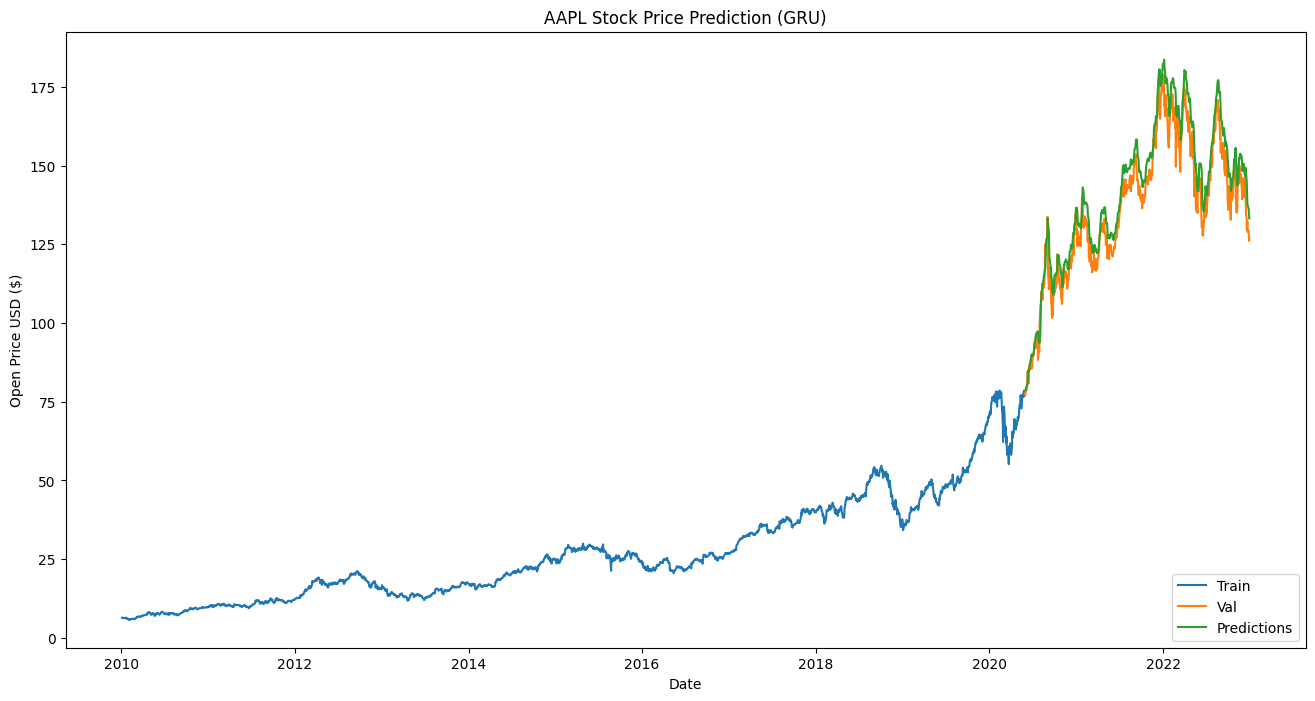

                                 Open       Close  Predictions
Date                                                          
2020-05-29 00:00:00-04:00   77.420268   77.102585    78.574539
2020-06-01 00:00:00-04:00   77.056502   78.050781    78.664917
2020-06-02 00:00:00-04:00   77.784026   78.412117    78.656029
2020-06-03 00:00:00-04:00   78.732230   78.843781    78.868126
2020-06-04 00:00:00-04:00   78.666747   78.164757    79.378342
...                               ...         ...          ...
2022-12-23 00:00:00-05:00  128.974267  129.900299   137.422379
2022-12-27 00:00:00-05:00  129.427446  128.097504   136.289597
2022-12-28 00:00:00-05:00  127.742826  124.166779   135.502350
2022-12-29 00:00:00-05:00  126.087843  127.683769   134.479355
2022-12-30 00:00:00-05:00  126.501571  127.998970   133.178467

[654 rows x 3 columns]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import yfinance as yf

# Fetch stock data
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval="1d")
    return data

ticker = 'AAPL'
data = fetch_stock_data(ticker, start_date='2010-01-01', end_date='2023-01-01')
print(data.head())

data = data.sort_index()
data = data[['Open', 'Close']]
dataset = data.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(dataset) * 0.8))
train_data = scaled_data[:training_data_len]

# Create training sequences
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build GRU model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create test sequences
test_data = scaled_data[training_data_len - 60:]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict
predictions = model.predict(x_test)

# Inverse scale predictions
open_scaler = MinMaxScaler()
open_scaler.min_, open_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
predictions = open_scaler.inverse_transform(predictions)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test[:, 0], predictions[:, 0]))
mae = mean_absolute_error(y_test[:, 0], predictions[:, 0])
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

# Plot results
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('AAPL Stock Price Prediction (GRU)')
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Print actual vs predicted
print(valid)
